## Setup

In [1]:
! pip install datasets -Uqq
! pip install transformers[sentencepiece] -Uqq
! pip install git+https://github.com/ohmeow/blurr.git@dev-2.0.0 -Uqq
! pip install -U nltk -Uqq
! pip install sacrebleu -Uqq

     |████████████████████████████████| 312 kB 5.3 MB/s 
     |████████████████████████████████| 134 kB 46.5 MB/s 
     |████████████████████████████████| 1.1 MB 42.9 MB/s 
     |████████████████████████████████| 212 kB 52.2 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 127 kB 42.1 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 50.5 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.5 MB/s 
     |████████████████████████████████| 895 kB 33.8 MB/s 
     |████████████████████████████████| 6.5 MB 39.7 MB/s 
     |████████████████████████████████| 596

## Loading Data

In [2]:
import pandas 
from datasets import load_dataset

In [3]:
raw_datasets = load_dataset("opus_books", "en-es", split="train[:100]")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.26M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-es/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


In [4]:
raw_datasets[0]

{'id': '0',
 'translation': {'en': 'Source: Project GutenbergAudiobook available here',
  'es': 'Source: Wikisource & librodot.com'}}

In [5]:
from blurr.data.all import *
from blurr.modeling.all import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.learner import *
from fastai.optimizer import *
from transformers import *

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

# Blurr Bits of Translation

In [6]:
pretrained_model_name = "Helsinki-NLP/opus-mt-en-es"
model_cls = AutoModelForSeq2SeqLM
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

('marian',
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [7]:
translation_df = pd.DataFrame(raw_datasets["translation"], columns=["en", "es"])
len(translation_df)

100

In [8]:
translation_df.head()

,en,es
0,Source: Project GutenbergAudiobook available here,Source: Wikisource & librodot.com
1,Sense and Sensibility,SENTIDO Y SENSIBILIDAD
2,Jane Austen,JANE AUSTEN
3,CHAPTER 1,CAPITULO I
4,The family of Dashwood had long been settled in Sussex.,La familia Dashwood llevaba largo tiempo afincada en Sussex.


In [9]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("en"), get_y=ColReader("es"), splitter=RandomSplitter())

In [10]:
dls = dblock.dataloaders(translation_df, bs=1)
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=10, target_trunc_at=250)

,text,target
0,No▁one▁cou,"Nadie podía discutirle su derecho a venir: la casa pertenecía a su esposo desde el momento mismo de la muerte de su padre. Pero eso mismo agravaba la falta de delicadeza de su conducta, y no se necesitaba ninguna sensibilidad especial para que cualqu"


In [11]:
translation_df.shape

(100, 2)

## Blurr High-level API

In [12]:
learn = BlearnerForTranslation.from_data(
    translation_df,
    pretrained_model_name,
    src_lang_name="English",
    src_lang_attr="en",
    trg_lang_name="Spanish",
    trg_lang_attr="es",
    dl_kwargs={"bs": 4},
)

In [13]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(5, lr_max=4e-5, cbs=[metrics_cb])

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Downloading:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,1.787218,1.612933,0.308540,0.535983,30.824969,00:09
1,1.576542,1.586422,0.306881,0.519793,30.402971,00:06
2,1.362832,1.579899,0.297741,0.518022,29.117156,00:07
3,1.191016,1.586241,0.308184,0.530238,30.199438,00:07
4,1.081719,1.587277,0.312583,0.526900,30.846458,00:07


In [14]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"▁But her▁death,▁which▁happened ten▁years▁before▁his▁own,▁produced a▁great▁alteration in▁his home; for to▁supply her▁loss, he▁invited and▁received▁into▁his▁house the▁family of▁his▁nephew Mr. Henry▁Dashwood, the legal▁inheritor of the▁Norland▁estate, and the person to▁whom he▁intended to bequeath▁it.","Pero la muerte de ella, ocurrida diez años antes que la suya, produjo grandes alteraciones en su hogar. Para compensar tal pérdida, invitó y recibió en su casa a la familia de su sobrino, el señor Henry Dashwood, el legítimo heredero de la finca Norl","[Pero su muerte, que ocurrió diez años antes de la suya, produjo una gran alteración en su casa; para suplir su pérdida, invitó y recibió en su casa a la familia de su sobrino, el señor Henry Dashwood, heredero legal de la hacienda de Norland, y a la persona a quien tenía la intención de legarla., La decepción del señor Dashwood fue, en un principio, severa, pero su temperamento era alegre y sanguinario; y podría razonablemente esperar vivir muchos años, y al vivir económicamente, radicaba en una considerable suma de los productos de una finca ya grande y capaz de lograr una mejora casi inmediata., Para él, por lo tanto, la sucesión a la propiedad de Norland no era tan importante como para sus hermanas, ya que su fortuna, independiente de lo que pudiera surgirles de la herencia de su padre, podía ser pequeña., -Era la última petición de mi padre para mí -respondió su esposo-, que ayudara a su viuda e hijas. No sabía de qué hablaba, me atrevo a decir, diez a uno, pero en aquel momento se sintió aturdido.]"


## Mid-level APIs of Blurr

In [15]:
b = dls.one_batch()

In [16]:
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([1, 112]), torch.Size([1, 119]))

In [17]:
dls.show_batch(dataloaders=dls, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"No▁one▁could▁dispute her▁right to come; the▁house▁was her▁husband's from the▁moment of▁his▁father's decease;▁but the indelicacy of her▁conduct▁was so▁much the▁greater, and to a▁woman in▁Mrs.▁Dashwood's▁situation, with▁only▁common▁feelings,▁must▁have▁","Nadie podía discutirle su derecho a venir: la casa pertenecía a su esposo desde el momento mismo de la muerte de su padre. Pero eso mismo agravaba la falta de delicadeza de su conducta, y no se necesitaba ninguna sensibilidad especial para que cualqu"


In [18]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape

(3, torch.Size([]), torch.Size([1, 119, 65001]))

In [20]:


len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape



(2, 3, torch.Size([1, 112]), 1, torch.Size([1, 119]))

In [21]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=1.318256749982538e-07, steep=0.00010964782268274575, valley=5.248074739938602e-05, slide=1.737800812406931e-05)

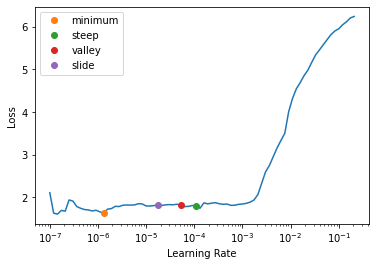

In [22]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [23]:
learn.fit_one_cycle(1, lr_max=1.4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,1.656293,1.751224,0.299545,0.517764,29.750768,00:22


In [24]:


learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)



,text,target,prediction
0,"The▁whole▁was▁tied▁up for the▁benefit of this▁child,▁who, in▁occasional▁visits with▁his▁father and▁mother▁at▁Norland,▁had so▁far▁gained on the▁affections of▁his▁uncle, by▁such▁attractions▁as▁are by no▁means▁unusual in▁children of▁two or▁three▁years▁old;▁an▁imperfect▁articulation,▁an▁earnest▁desire of▁having▁his▁own▁way,▁many▁cunning▁tricks, and a▁great▁deal of▁noise,▁as to▁outweigh▁all the▁value of▁all the▁attention▁which, for▁years, he▁had▁received from▁his▁niece and her▁daughters.","Se habían tomado las provisiones necesarias para asegurar que todo fuera en beneficio de este niño, el cual, en sus ocasionales visitas a Norland con su padre y su madre, había conquistado el afecto de su tío con aquellos rasgos seductores que no suelen escasear en los niños de dos o tres años: una pronunciación imperfecta, el inquebrantable deseo de hacer siempre su voluntad, incontables jugarretas y artimañas y ruido por montones, gracias que finalmente terminaron por desplazar el valor de tod","El todo estaba atado en beneficio de este niño, que, en visitas ocasionales con su padre y su madre en Norland, había ganado hasta ahora en los afectos de su tío, por las atracciones que no son en modo alguno inusuales en los hijos de dos o tres años de edad; una articulación imperfecta, un deseo ferviente de tener su propio camino, muchas astucias, y mucho ruido, como para superar todo el valor de toda la atención que, durante años, había recibido de su sobrina y sus hijas."


## Translation inference

In [25]:
test_de = "How are you doing"


outputs = learn.blurr_generate(test_de, key="translation_texts", num_return_sequences=3)
outputs

[{'translation_texts': ['¿Cómo estás?', '¿Cómo te va?', '¿Cómo lo llevas?']}]

In [26]:
export_fname = "translation_export"


learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")

In [27]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_de)

[{'translation_texts': '¿Cómo estás?'}]